<a href="https://colab.research.google.com/github/EkaterinaVoloshina/DLforNLP/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import json
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
device = 'cuda:0'

In [5]:
def seed_everything(seed: int): # код из тетрадки по иаду, чтобы зафиксировать все
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [6]:
seed_everything(42)

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [7]:
!wget https://github.com/semensorokin/DL_for_NLP_2021/blob/year21-22/homework2/data/processed_corpus.json.zip?raw=true
!unzip processed_corpus.json.zip\?raw\=true

--2021-11-20 18:36:39--  https://github.com/semensorokin/DL_for_NLP_2021/blob/year21-22/homework2/data/processed_corpus.json.zip?raw=true
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/semensorokin/DL_for_NLP_2021/raw/year21-22/homework2/data/processed_corpus.json.zip [following]
--2021-11-20 18:36:39--  https://github.com/semensorokin/DL_for_NLP_2021/raw/year21-22/homework2/data/processed_corpus.json.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/semensorokin/DL_for_NLP_2021/year21-22/homework2/data/processed_corpus.json.zip [following]
--2021-11-20 18:36:40--  https://raw.githubusercontent.com/semensorokin/DL_for_NLP_2021/year21-22/homework2/data/processed_corpus.json.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 

In [8]:
!wget https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv

--2021-11-20 18:36:41--  https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv
Resolving rusvectores.org (rusvectores.org)... 116.203.104.23
Connecting to rusvectores.org (rusvectores.org)|116.203.104.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42924 (42K) [text/tab-separated-values]
Saving to: ‘ru_simlex965_tagged.tsv’

ru_simlex965_tagged 100%[===================>]  41.92K   159KB/s    in 0.3s    

2021-11-20 18:36:43 (159 KB/s) - ‘ru_simlex965_tagged.tsv’ saved [42924/42924]



In [9]:
with open('processed_corpus.json') as f:
    corpus = json.load(f)

In [10]:
len(corpus)

100000

In [11]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [12]:
sample_text = corpus[1]

In [13]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

# Реализуйте разделение предложения на примеры методом CBOW

In [14]:
def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []
    for num, token in enumerate(tokens):
      left = tokens[max(0, num - window):num]
      left = [pad_token] * (window - len(left)) + left
      right = tokens[num + 1:(num + window + 1)]
      right += [pad_token] * (window - len(right))       
      splits.append([left, token, right])
    # CODE
    return splits

In [15]:
splits = cbow_split(sample_text, window=2)

In [16]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: вернуть
Правый контекст: ['денежный', 'средство']

Левый контекст: ['PAD', 'вернуть']
Центральное слово: денежный
Правый контекст: ['средство', 'лицевой']

Левый контекст: ['вернуть', 'денежный']
Центральное слово: средство
Правый контекст: ['лицевой', 'счёт']

Левый контекст: ['денежный', 'средство']
Центральное слово: лицевой
Правый контекст: ['счёт', 'либо']

Левый контекст: ['средство', 'лицевой']
Центральное слово: счёт
Правый контекст: ['либо', 'зачесть']

Левый контекст: ['лицевой', 'счёт']
Центральное слово: либо
Правый контекст: ['зачесть', 'счёт']

Левый контекст: ['счёт', 'либо']
Центральное слово: зачесть
Правый контекст: ['счёт', 'погашение']

Левый контекст: ['либо', 'зачесть']
Центральное слово: счёт
Правый контекст: ['погашение', 'кредит']

Левый контекст: ['зачесть', 'счёт']
Центральное слово: погашение
Правый контекст: ['кредит', 'PAD']

Левый контекст: ['счёт', 'погашение']
Центральное слово: кредит
Правый контекст: [

In [17]:
splits

[[['PAD', 'PAD'], 'вернуть', ['денежный', 'средство']],
 [['PAD', 'вернуть'], 'денежный', ['средство', 'лицевой']],
 [['вернуть', 'денежный'], 'средство', ['лицевой', 'счёт']],
 [['денежный', 'средство'], 'лицевой', ['счёт', 'либо']],
 [['средство', 'лицевой'], 'счёт', ['либо', 'зачесть']],
 [['лицевой', 'счёт'], 'либо', ['зачесть', 'счёт']],
 [['счёт', 'либо'], 'зачесть', ['счёт', 'погашение']],
 [['либо', 'зачесть'], 'счёт', ['погашение', 'кредит']],
 [['зачесть', 'счёт'], 'погашение', ['кредит', 'PAD']],
 [['счёт', 'погашение'], 'кредит', ['PAD', 'PAD']]]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [18]:
cbow_split(sample_text, window=3)

[[['PAD', 'PAD', 'PAD'], 'вернуть', ['денежный', 'средство', 'лицевой']],
 [['PAD', 'PAD', 'вернуть'], 'денежный', ['средство', 'лицевой', 'счёт']],
 [['PAD', 'вернуть', 'денежный'], 'средство', ['лицевой', 'счёт', 'либо']],
 [['вернуть', 'денежный', 'средство'], 'лицевой', ['счёт', 'либо', 'зачесть']],
 [['денежный', 'средство', 'лицевой'], 'счёт', ['либо', 'зачесть', 'счёт']],
 [['средство', 'лицевой', 'счёт'], 'либо', ['зачесть', 'счёт', 'погашение']],
 [['лицевой', 'счёт', 'либо'], 'зачесть', ['счёт', 'погашение', 'кредит']],
 [['счёт', 'либо', 'зачесть'], 'счёт', ['погашение', 'кредит', 'PAD']],
 [['либо', 'зачесть', 'счёт'], 'погашение', ['кредит', 'PAD', 'PAD']],
 [['зачесть', 'счёт', 'погашение'], 'кредит', ['PAD', 'PAD', 'PAD']]]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [19]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

# Реализуйте разделение предложения на примеры методом Skipgram

In [20]:
def skipgram_split(tokens, window):
    
    splits = []
    
    # CODE
    for num, token in enumerate(tokens):
      context = tokens[max(0, num - window):num] + tokens[num + 1:(num + window + 1)]
      for word in context:
        splits.append((word, token))
    return splits

In [21]:
splits = skipgram_split(sample_text, window=2)

In [22]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: денежный
Центральное слово: вернуть

Контекст: средство
Центральное слово: вернуть

Контекст: вернуть
Центральное слово: денежный

Контекст: средство
Центральное слово: денежный

Контекст: лицевой
Центральное слово: денежный

Контекст: вернуть
Центральное слово: средство

Контекст: денежный
Центральное слово: средство

Контекст: лицевой
Центральное слово: средство

Контекст: счёт
Центральное слово: средство

Контекст: денежный
Центральное слово: лицевой

Контекст: средство
Центральное слово: лицевой

Контекст: счёт
Центральное слово: лицевой

Контекст: либо
Центральное слово: лицевой

Контекст: средство
Центральное слово: счёт

Контекст: лицевой
Центральное слово: счёт

Контекст: либо
Центральное слово: счёт

Контекст: зачесть
Центральное слово: счёт

Контекст: лицевой
Центральное слово: либо

Контекст: счёт
Центральное слово: либо

Контекст: зачесть
Центральное слово: либо

Контекст: счёт
Центральное слово: либо

Контекст: счёт
Центральное слово: зачесть

Контекст: либо
Цент

In [23]:
skipgram_split(sample_text, window=2)

[('денежный', 'вернуть'),
 ('средство', 'вернуть'),
 ('вернуть', 'денежный'),
 ('средство', 'денежный'),
 ('лицевой', 'денежный'),
 ('вернуть', 'средство'),
 ('денежный', 'средство'),
 ('лицевой', 'средство'),
 ('счёт', 'средство'),
 ('денежный', 'лицевой'),
 ('средство', 'лицевой'),
 ('счёт', 'лицевой'),
 ('либо', 'лицевой'),
 ('средство', 'счёт'),
 ('лицевой', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('лицевой', 'либо'),
 ('счёт', 'либо'),
 ('зачесть', 'либо'),
 ('счёт', 'либо'),
 ('счёт', 'зачесть'),
 ('либо', 'зачесть'),
 ('счёт', 'зачесть'),
 ('погашение', 'зачесть'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('погашение', 'счёт'),
 ('кредит', 'счёт'),
 ('зачесть', 'погашение'),
 ('счёт', 'погашение'),
 ('кредит', 'погашение'),
 ('счёт', 'кредит'),
 ('погашение', 'кредит')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [24]:
skipgram_split(sample_text, window=3)

[('денежный', 'вернуть'),
 ('средство', 'вернуть'),
 ('лицевой', 'вернуть'),
 ('вернуть', 'денежный'),
 ('средство', 'денежный'),
 ('лицевой', 'денежный'),
 ('счёт', 'денежный'),
 ('вернуть', 'средство'),
 ('денежный', 'средство'),
 ('лицевой', 'средство'),
 ('счёт', 'средство'),
 ('либо', 'средство'),
 ('вернуть', 'лицевой'),
 ('денежный', 'лицевой'),
 ('средство', 'лицевой'),
 ('счёт', 'лицевой'),
 ('либо', 'лицевой'),
 ('зачесть', 'лицевой'),
 ('денежный', 'счёт'),
 ('средство', 'счёт'),
 ('лицевой', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('счёт', 'счёт'),
 ('средство', 'либо'),
 ('лицевой', 'либо'),
 ('счёт', 'либо'),
 ('зачесть', 'либо'),
 ('счёт', 'либо'),
 ('погашение', 'либо'),
 ('лицевой', 'зачесть'),
 ('счёт', 'зачесть'),
 ('либо', 'зачесть'),
 ('счёт', 'зачесть'),
 ('погашение', 'зачесть'),
 ('кредит', 'зачесть'),
 ('счёт', 'счёт'),
 ('либо', 'счёт'),
 ('зачесть', 'счёт'),
 ('погашение', 'счёт'),
 ('кредит', 'счёт'),
 ('либо', 'погашение'),
 ('зачесть', 'погашени

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [25]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [26]:
len(word2index)

13076

In [27]:
word2index['UNK']

1

In [28]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [29]:
from torch.utils.data import Dataset, DataLoader

In [30]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [31]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.37454012, 0.95071431, 0.73199394, 0.59865848],
       [0.15601864, 0.15599452, 0.05808361, 0.86617615],
       [0.60111501, 0.70807258, 0.02058449, 0.96990985],
       [0.83244264, 0.21233911, 0.18182497, 0.18340451],
       [0.30424224, 0.52475643, 0.43194502, 0.29122914],
       [0.61185289, 0.13949386, 0.29214465, 0.36636184],
       [0.45606998, 0.78517596, 0.19967378, 0.51423444],
       [0.59241457, 0.04645041, 0.60754485, 0.17052412],
       [0.06505159, 0.94888554, 0.96563203, 0.80839735],
       [0.30461377, 0.09767211, 0.68423303, 0.44015249]])

In [32]:
some_data_y

array([0, 2, 2, ..., 2, 2, 0])

In [33]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [34]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [35]:
some_dataset[5], some_dataset[467]

((array([0.61185289, 0.13949386, 0.29214465, 0.36636184]), 1),
 (array([0.13172877, 0.72597991, 0.81778533, 0.21351137]), 2))

In [36]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [37]:
for x, y in some_loader:
    break
    
len(x), x

(16, tensor([[0.0772, 0.7549, 0.0790, 0.8379],
         [0.9353, 0.4053, 0.5860, 0.1536],
         [0.5732, 0.2436, 0.0570, 0.4655],
         [0.0437, 0.3600, 0.1619, 0.5312],
         [0.2923, 0.7049, 0.6742, 0.1578],
         [0.0644, 0.0459, 0.5824, 0.4634],
         [0.7510, 0.7080, 0.0265, 0.6331],
         [0.4240, 0.9184, 0.5407, 0.9316],
         [0.7336, 0.8633, 0.5764, 0.4289],
         [0.2290, 0.4960, 0.4552, 0.5490],
         [0.1551, 0.2273, 0.4652, 0.9202],
         [0.7362, 0.8857, 0.4358, 0.4822],
         [0.8109, 0.1305, 0.7247, 0.4447],
         [0.9590, 0.3071, 0.7968, 0.5337],
         [0.4451, 0.0543, 0.1099, 0.0239],
         [0.0308, 0.4339, 0.2747, 0.7114]], dtype=torch.float64))

In [38]:
for x, y in some_loader:
    pass

len(x)

15

In [39]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [40]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [41]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [42]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [43]:
for x, y in toy_loader:
    break

In [44]:
x.shape

torch.Size([128, 32])

In [45]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[ 3.7454e-01,  9.5071e-01,  7.3199e-01,  ..., -3.0325e-01,
         -1.8719e+00, -3.0784e+00],
        [ 1.5602e-01,  1.5599e-01,  5.8084e-02,  ..., -1.1148e+01,
         -1.7075e+01, -8.6200e-01],
        [ 6.0112e-01,  7.0807e-01,  2.0584e-02,  ..., -2.0713e+00,
         -2.3299e+01, -1.8331e-01],
        ...,
        [ 6.9816e-01,  5.3610e-01,  3.0953e-01,  ..., -3.7406e+00,
         -7.0362e+00, -1.2363e+00],
        [ 6.8473e-01,  1.6262e-01,  9.1093e-01,  ..., -1.0898e+01,
         -5.5975e-01, -1.1722e+00],
        [ 9.4980e-01,  7.2572e-01,  6.1342e-01,  ..., -1.9236e+00,
         -2.9323e+00, -5.2302e+00]], dtype=torch.float64)

In [46]:
y

tensor([0, 2, 2, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 2, 1, 1, 0, 2, 1, 2, 1, 1,
        1, 0, 1, 1, 1, 1, 2, 0, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 0, 2, 2, 2, 0, 2,
        0, 0, 1, 2, 1, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2,
        0, 2, 2, 1, 1, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 1, 0, 2, 1, 0, 2, 0, 2,
        2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 0, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 1, 1, 2,
        2, 1, 1, 0, 1, 0, 2, 1])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [47]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [48]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.1174144744873047

# Боевые датасеты

In [49]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [50]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []
        # CODE
        for num, token in enumerate(tokenized_text):
            context = tokenized_text[max(0, num - self.window):num] + tokenized_text[num + 1:(num + self.window + 1)]
            for word in context:
                splits.append((word, token))
        # вставить здесь функцию, которые вы писали раньше

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        # CODE
        context, central_word = self.data[idx]

        return context, central_word

In [51]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его 
#from .word2vec_utils import SkipgramDataset

In [52]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 100000/100000 [00:02<00:00, 45053.04it/s]


In [53]:
BATCH_SIZE = 512

In [54]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [55]:
for x, y in dataset_loader:
    break

In [56]:
x[:5]

tensor([313,  21,  21, 350,  32])

In [57]:
y[:5]

tensor([555,  25, 233, 128,  48])

In [58]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [59]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [60]:
# CODE
class SkipGram(torch.nn.Module):
  def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size
      )
        
  def forward(self, x):
        
        x = self.in_embedding(x)
        x = self.out_embedding(x)
        
        return x

In [61]:
#from word2vec_utils import SkipGram

In [62]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [63]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [64]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13076])

In [65]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()
criterion.to(device)

CrossEntropyLoss()

# Допишите обучалку

In [66]:
epochs = 3

losses = []

model.train()
model.to(device)

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            # CODE
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            
            # CODE
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████| 2983124/2983124 [00:59<00:00, 50204.74it/s, loss=7.41]


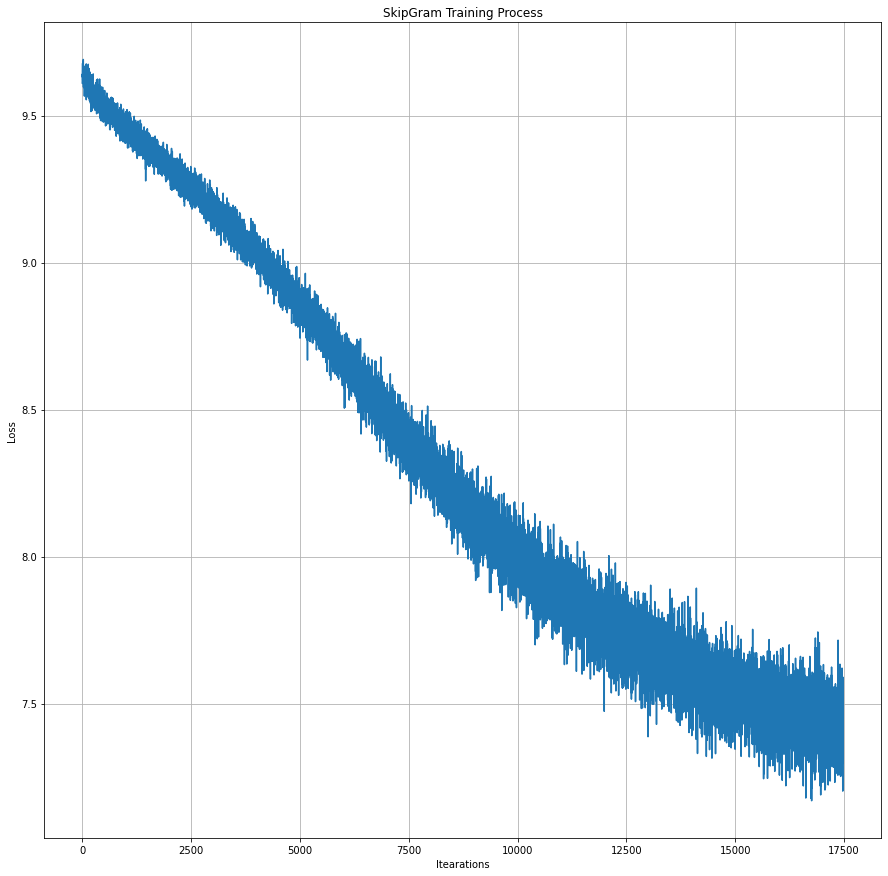

In [67]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [68]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [69]:
np.mean(losses[-1000:])

7.436925002098084

In [70]:
initial_loss = np.mean(losses)

In [71]:
embedding_matrix = model.in_embedding.weight.detach().cpu()

In [72]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [73]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.29659053683280945

In [74]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.3579026758670807

In [75]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.36926335096359253

In [76]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.423010915517807

In [77]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "майла" равна -0.136'

In [78]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [79]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [80]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.001s...
[t-SNE] Computed neighbors for 13076 samples in 4.509s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sam

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 98.8143616, gradient norm = 0.0000032 (50 iterations in 17.647s)
[t-SNE] Iteration 100: error = 98.8152466, gradient norm = 0.0000000 (50 iterations in 4.206s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations with early exaggeration: 98.815247
[t-SNE] Iteration 150: error = 5.7479382, gradient norm = 0.0000000 (50 iterations in 4.690s)
[t-SNE] Iteration 150: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 150 iterations: 5.747938


In [81]:
top_words = [a for a,_ in top_sorted_freq]

In [82]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

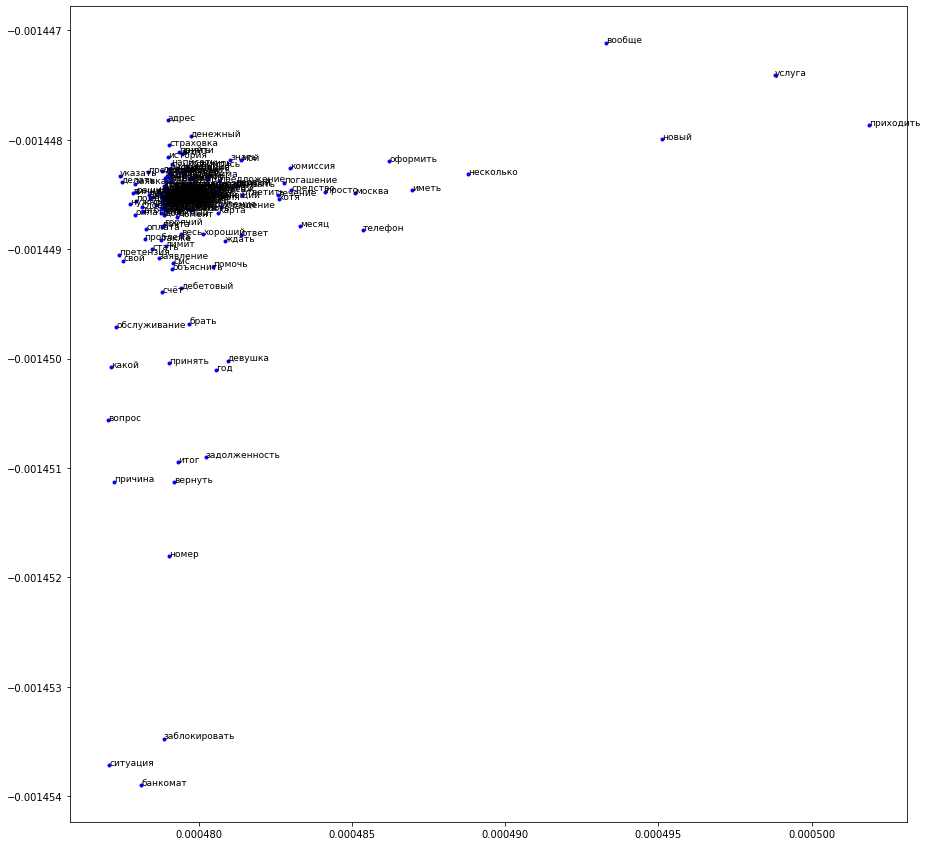

In [83]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x, y, word, fontsize=9)
plt.show()

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов - Взяли корпус для оценка качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если в кратце - он похож а гугл аналогии, просто иначе составлен. Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем что у вас и что в оригинале.
3. 9 баллов - Поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов - удивили своим подходом (или просто удивили) пока делили на 9 баллов

Проверим на корпусе для оценки качества эмбеддингов:

In [84]:
simlex = pd.read_csv('ru_simlex965_tagged.tsv', sep='\t')

In [85]:
def calculate_cos(embedding_matrix, word2index, row):
    word1 = row[0].split('_')[0]
    word2 = row[1].split('_')[0]
    if word1 in word2index and word2 in word2index:
        return cos_sim(embedding_matrix, word2index, word1, word2)

In [86]:
simlex['cos_score'] = simlex.apply(lambda x: calculate_cos(embedding_matrix, word2index, x), axis=1)

In [87]:
def calculate_mse(simlex, coslex):
    cos_scaler = MinMaxScaler().fit_transform(np.expand_dims(coslex, axis=-1))
    sim_scaler = MinMaxScaler().fit_transform(np.expand_dims(simlex, axis=-1))
    return mean_squared_error(sim_scaler, cos_scaler)

In [88]:
simlex = simlex[simlex['cos_score'].notna()]

In [89]:
initial_mse = calculate_mse(np.array(simlex['Average Score']), np.array(simlex['cos_score']))

In [90]:
initial_mse

0.15715352912664102

Проведем несколько экспериментов с разными гиперпараметрами модели:

In [91]:
def train(word2index, epochs=3, emb_size=20, lr=0.0001, scheduler_on=False):

    losses = []
    model = SkipGram(vocab_size=len(word2index), embedding_dim=emb_size)
    model.train()
    model.to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.7)

    criterion = torch.nn.CrossEntropyLoss()
    criterion.to(device)

    for n_epoch in range(epochs):


        try:

            progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

            for x, y in dataset_loader:

                # CODE
                x = x.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                pred = model(x)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
                
                # CODE
                
                losses.append(loss.item())
                
                progress_bar.set_postfix(loss=np.mean(losses[-100:]))

                progress_bar.update(x.shape[0])

            if scheduler_on:
                scheduler.step()

            progress_bar.close()

        except KeyboardInterrupt:

            progress_bar.close()
            break

    return np.mean(losses), model.in_embedding.weight.detach().cpu()

Посмотрим, как влияет увеличение эпох на качество модели:

In [92]:
loss, matrix = train(word2index, epochs=5) 

Epoch 5: 100%|██████████| 2983124/2983124 [00:59<00:00, 49807.69it/s, loss=7.17]


In [93]:
print(f'Первоначальный лосс: {initial_loss} \nЛосс с увеличением эпох: {loss}')
score = simlex.apply(lambda x: calculate_cos(matrix, word2index, x), axis=1)
print(f'Первоначальный MSE: {initial_mse} \nMSE: {calculate_mse(np.array(simlex["Average Score"]), np.array(score))}')

Первоначальный лосс: 8.322237032446298 
Лосс с увеличением эпох: 7.89467728176022
Первоначальный MSE: 0.15715352912664102 
MSE: 0.16953123699373424


Теперь увеличим размер эмбеддингов:

In [94]:
loss, matrix = train(word2index, emb_size=300) 

Epoch 3: 100%|██████████| 2983124/2983124 [01:49<00:00, 27265.64it/s, loss=6.79]


In [95]:
print(f'Первоначальный лосс: {initial_loss} \nЛосс с увеличением размера эмбеддинга: {loss}')
score = simlex.apply(lambda x: calculate_cos(matrix, word2index, x), axis=1)
print(f'Первоначальный MSE: {initial_mse} \nMSE: {calculate_mse(np.array(simlex["Average Score"]), np.array(score))}')

Первоначальный лосс: 8.322237032446298 
Лосс с увеличением размера эмбеддинга: 7.380397711061489
Первоначальный MSE: 0.15715352912664102 
MSE: 0.13777456417435904


При увеличении размера эмбеддингов лосс падает!

Теперь попробуем поэкспериментировать с learning rate:

In [96]:
loss, matrix = train(word2index, lr=0.001)

Epoch 3: 100%|██████████| 2983124/2983124 [00:58<00:00, 51119.45it/s, loss=6.84]


In [97]:
print(f'Первоначальный лосс: {initial_loss} \nЛосс с увеличением learning_rate: {loss}')
score = simlex.apply(lambda x: calculate_cos(matrix, word2index, x), axis=1)
print(f'Первоначальный MSE: {initial_mse} \nMSE: {calculate_mse(np.array(simlex["Average Score"]), np.array(score))}')

Первоначальный лосс: 8.322237032446298 
Лосс с увеличением learning_rate: 7.092199539280369
Первоначальный MSE: 0.15715352912664102 
MSE: 0.14632602850664622


In [98]:
loss, matrix = train(word2index, lr=0.005)

Epoch 3: 100%|██████████| 2983124/2983124 [00:58<00:00, 51129.45it/s, loss=6.71]


In [99]:
print(f'Первоначальный лосс: {initial_loss} \nЛосс с увеличением learning_rate: {loss}')
score = simlex.apply(lambda x: calculate_cos(matrix, word2index, x), axis=1)
print(f'Первоначальный MSE: {initial_mse} \nMSE: {calculate_mse(np.array(simlex["Average Score"]), np.array(score))}')

Первоначальный лосс: 8.322237032446298 
Лосс с увеличением learning_rate: 6.839078910535877
Первоначальный MSE: 0.15715352912664102 
MSE: 0.13053612492615238


Лосс меньше с learning rate 0.05

Добавим scheduler, чтобы динамически менять learning rate:

In [100]:
loss, matrix = train(word2index, scheduler_on=True)

Epoch 3: 100%|██████████| 2983124/2983124 [00:59<00:00, 50362.83it/s, loss=7.68]


In [101]:
print(f'Первоначальный лосс: {initial_loss} \nЛосс с увеличением learning_rate: {loss}')
score = simlex.apply(lambda x: calculate_cos(matrix, word2index, x), axis=1)
print(f'Первоначальный MSE: {initial_mse} \nMSE: {calculate_mse(np.array(simlex["Average Score"]), np.array(score))}')

Первоначальный лосс: 8.322237032446298 
Лосс с увеличением learning_rate: 8.448399608082442
Первоначальный MSE: 0.15715352912664102 
MSE: 0.15531272040156285


В целом scheduler не помогает улучшать метрики

Сработало увеличение learning rate и размера эмбеддингов, попробуем объединить это:

In [102]:
loss, matrix = train(word2index, emb_size=300, lr=0.005)

Epoch 3: 100%|██████████| 2983124/2983124 [01:50<00:00, 27089.09it/s, loss=6.71]


In [103]:
print(f'Первоначальный лосс: {initial_loss} \nЛосс с увеличением learning_rate: {loss}')
score = simlex.apply(lambda x: calculate_cos(matrix, word2index, x), axis=1)
print(f'Первоначальный MSE: {initial_mse} \nMSE: {calculate_mse(np.array(simlex["Average Score"]), np.array(score))}')

Первоначальный лосс: 8.322237032446298 
Лосс с увеличением learning_rate: 6.866868050118468
Первоначальный MSE: 0.15715352912664102 
MSE: 0.095135669254915


Лосс и MSE сильно упали, поэтому остановимся на этой модели!